In [183]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 199)
pd.options.display.float_format = '{:.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
nyt_cum = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\594\Data\NYT COVID Data.csv", parse_dates=['date'])
nyt_non_cum = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\594\Data\NYT non-cumulative COVID data.csv", parse_dates=['date'])

county_pop = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\594\Data\County pop data.csv")

suburban_rural = pd.read_excel(r"C:/Users/mikha/OneDrive/Desktop/Dropbox/MIKHAEL NEW/mikhael school/Grad School/Master's/594/Data/Suburban vs Rural County Classifications.xlsx")

# Add "FIPS" column to county population dataset (thanks, census)

In [ ]:
def add_leading_zero(number_str):
    
    if len(number_str) == 1:
        return "0" + number_str
    
    else:
        return number_str
    
    
def add_two_leading_zeros(number_str):
    
    if len(number_str) == 2:
        return "0" + number_str
    
    elif  len(number_str) == 1:
        return "00" + number_str
    
    else:
        return number_str

county_pop['STATE'] = county_pop['STATE'].astype(str).apply(add_leading_zero)
county_pop['COUNTY'] = county_pop['COUNTY'].astype(str).apply(add_two_leading_zeros)

county_pop['FIPS'] = (county_pop['STATE'] + county_pop['COUNTY']).astype(int)

# Merge county population and suburban/rural classification datasets

In [ ]:
suburban_rural.rename(columns={'FIPS code':'FIPS', '2013 code':'Urban/Rural'}, inplace=True)

In [ ]:
county_info = county_pop.merge(suburban_rural, 
                               how='outer',
                               on='FIPS')

In [ ]:
for col in ['SUMLEV','REGION','DIVISION','STATE','COUNTY','STNAME']:
    del county_info[col]

In [ ]:
county_info['FIPS'] = county_info['FIPS'].astype(float)

# Merge NYT datasets

## Get FIPS in non-cumulative nyt dataset

In [ ]:
def split_geoid_into_FIPS(geoid):
    return geoid.split('-')[1]

## Process and rename

In [ ]:
nyt_non_cum['FIPS'] = nyt_non_cum['geoid'].apply(split_geoid_into_FIPS)

nyt_cum.rename(columns={'fips':'FIPS', 'cases':'Cum. Cases', 'deaths':'Cum. Deaths'}, inplace=True)

nyt_non_cum['FIPS'] = nyt_non_cum['FIPS'].astype(float)

## Merge both nyt datasets

In [ ]:
nyt = nyt_cum.merge(nyt_non_cum,
                   how='outer',
                   on=['FIPS','date'],
                   suffixes=('_cum','_non_cum'))

### Replace "Unknown" entries with np.nan

In [ ]:
def repl_str(string):
    if string=='Unknown':
        return np.nan
    else:
        return string

nyt['county_cum'] = nyt['county_cum'].apply(repl_str)
nyt['county_non_cum'] = nyt['county_non_cum'].apply(repl_str)

nyt['state_cum'] = nyt['state_cum'].apply(repl_str)
nyt['state_non_cum'] = nyt['state_non_cum'].apply(repl_str)

### Delete redundant columns

In [ ]:
for col in ['geoid', 'cases_avg', 'cases_avg_per_100k', 'deaths_avg', 'deaths_avg_per_100k']:
    del nyt[col]

## Collapse NYT data by week and FIPS

In [ ]:
collapsed_nyt = nyt.set_index('date').groupby([pd.Grouper(freq='1W'), 'FIPS']).agg(
    {'cases':'sum',
     'deaths':'sum',
    'FIPS':'median'}).droplevel('FIPS').reset_index()

In [ ]:
collapsed_nyt['FIPS'] = collapsed_nyt['FIPS'].astype(int).astype(str)

In [ ]:
def add_leading_zero_nyt(number_str):
    
    if len(number_str) == 4:
        return "0" + number_str
    
    else:
        return number_str

In [ ]:
collapsed_nyt['FIPS'] = collapsed_nyt['FIPS'].apply(add_leading_zero_nyt).astype(float)

## Merge NYT data with county info

In [ ]:
final_county_df = collapsed_nyt.merge(county_info,
                           on='FIPS',
                           how='left')

### Get rid of error-inducing counties (puerto rico, deprecated, etc.)

In [ ]:
erroneous_counties = final_county_df[final_county_df['County name'].isnull()]['FIPS'].unique()

final_county_df = final_county_df[ ~final_county_df['FIPS'].isin(erroneous_counties) ]

### Set all negative cases and deaths to 0

In [ ]:
final_county_df[['cases', 'deaths']] = final_county_df[['cases', 'deaths']].clip(lower=0)

## Add log and arcsinh-transformed case and death stats

In [ ]:
final_county_df['log cases'] = final_county_df['cases'].apply(np.log)
final_county_df['log deaths'] = final_county_df['deaths'].apply(np.log)

final_county_df['arcsinh cases'] = np.arcsinh(final_county_df['cases'])
final_county_df['arcsinh deaths'] = np.arcsinh(final_county_df['deaths'])

final_county_df[['log cases', 'log deaths']] = final_county_df[['log cases', 'log deaths']].clip(lower=0)

In [188]:
final_county_df['cases per 100k'] = (final_county_df['cases'] / final_county_df['POPESTIMATE2019']) * 100000
final_county_df['deaths per 100k'] = (final_county_df['deaths'] / final_county_df['POPESTIMATE2019']) * 100000

final_county_df['log cases per 100k'] = final_county_df['cases per 100k'].apply(np.log)
final_county_df['log deaths per 100k'] = final_county_df['deaths per 100k'].apply(np.log)

final_county_df['arcsinh cases per 100k'] = np.arcsinh(final_county_df['cases per 100k'])
final_county_df['arcsinh deaths per 100k'] = np.arcsinh(final_county_df['deaths per 100k'])


<ipython-input-188-f0829fc68b82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_county_df['cases per 100k'] = (final_county_df['cases'] / final_county_df['POPESTIMATE2019']) * 100000
<ipython-input-188-f0829fc68b82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_county_df['deaths per 100k'] = (final_county_df['deaths'] / final_county_df['POPESTIMATE2019']) * 100000
<ipython-input-188-f0829fc68b82>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [190]:
final_county_df[['log cases per 100k', 'log deaths per 100k']] = final_county_df[['log cases per 100k', 'log deaths per 100k']].clip(lower=0)

C:\Users\mikha\Anaconda\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:>

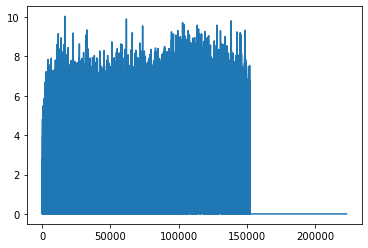

In [193]:
final_county_df['arcsinh cases per 100k'].plot()

In [194]:
final_county_df.to_csv(r"C:/Users/mikha/OneDrive/Desktop/Dropbox/MIKHAEL NEW/mikhael school/Grad School/Master's/594/Data/FINAL DF BEFORE CT MERGE.csv", index=False)